In [1]:
import os
os.chdir('../../') # run only once, to go to project's root

# AutoeXplainer usage

In this notebook, AutoeXplaienr is used to select the best explanation method for a sample dataset and model. Later, a report of the evaluation is generated.

In the second part, the Best Explanation wrapper of the selected method is used to easily generate explanations for new data

## Reading model and data

Selection of the best explanation method is based on a `torch.Tensor` of images. To make the computations shorter, in this example only 2 images will be used but to get more accurate results, a batch many more images should be used. 

The model is a DenseNet121 that has been trained on an Imagenette (10 class subset of Imagenet).


In [2]:
import torch
import torchvision

NUMBER_OF_IMAGES = 2

def densenet_with_imagenette(number_of_images=2):
    model = torch.load("development/models/chosen_model_imagenette_pretrained_097.pth", map_location="cpu")
    transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((256, 256)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    dataset = torchvision.datasets.ImageFolder("development/data/imagenette/", transform=transform)

    # for reproducibility of choosing images
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
    g = torch.Generator()
    g.manual_seed(25)
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=number_of_images, worker_init_fn=seed_worker, generator=g, shuffle=True)
    x_batch, y_batch = next(iter(data_loader))

    return model, x_batch, y_batch, 

model, x_batch, y_batch = densenet_with_imagenette(number_of_images=NUMBER_OF_IMAGES)

In [3]:
list_of_classes = ["tench", "English springer", "cassette player", "chain saw", "church", "French horn", "garbage truck", "gas pump", "golf ball", "parachute"]
labels = { i : label for i, label in enumerate(list_of_classes)}

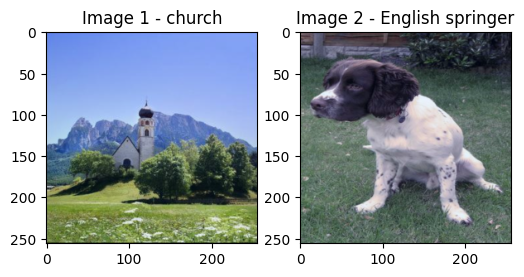

In [25]:
from autoexplainer.utils import normalize_image, torch_image_to_numpy_image
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,NUMBER_OF_IMAGES, figsize=(6, 6))

for i in range(NUMBER_OF_IMAGES):
    ax[i].imshow(normalize_image(torch_image_to_numpy_image(x_batch[i]))); 
    ax[i].set_title(f"Image {i+1} - {labels[y_batch[i].item()]}")

plt.show()

## AutoeXplainer - In short

Pass a model and a batch (torch.Tensor) of images with labels and view the results in a HTML report.


Preparing explanation methods and metric handlers...

	Number of explanation methods to evaluate:  4
	Explanation methods selected: KernelSHAP, Integrated Gradients, GradCam, Saliency

	Number of metrics used during evaluation:  4
	Metrics selected: Faithfulness Estimate, Average Sensitivity, Iterative Removal of Features, Sparseness


Creating attributions for saliency: 100%|██████████| 4/4 [00:56<00:00, 14.01s/it]            


Creating attribution finished. Starting evaluation.
Evaluation may take a very long time, please be patient...


Evaluating: method saliency and metric sparseness: 100%|██████████| 16/16 [37:12<00:00, 139.51s/it]                      


Evaluating metrics finished after 2456.238 seconds.


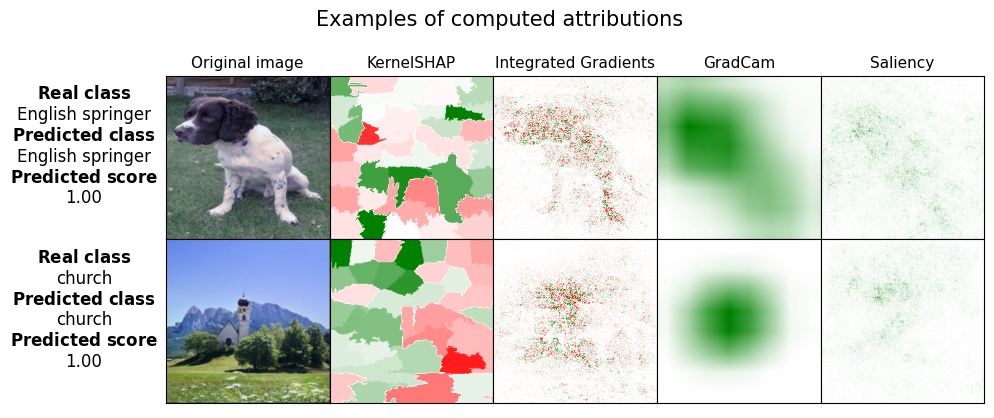

In [26]:
from autoexplainer.autoexplainer import AutoExplainer

explainer = AutoExplainer(model, x_batch, y_batch, device="cpu") # or device="cuda"
explainer.evaluate()
explainer.aggregate()
explainer.to_html('examples/example_report.html', model_name='DenseNet121', labels=labels)

Then, you can use the selected best explanation method to compute explanations for more images.

In [6]:
best_explanation = explainer.get_best_explanation()
new_attributions = best_explanation.explain(model, x_batch, y_batch)

Computing attributions using GradCam method.
This may take a while, depending on the number of samples to be explained.


Calculating attributions: 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

Finished.


To view the selected best explanation method name and its parameters, see `best_explanation.name` and `best_explanation.parameters` attributes.

## AutoeXplainer - Step by step

### Initialize

Pass a model, a batch of images (torch.Tensor) with labels. To use the GPU set `device='cuda'`.

In [7]:
from autoexplainer.autoexplainer import AutoExplainer

explainer = AutoExplainer(model, x_batch, y_batch, device="cpu") # or device="cuda"

### Evaluate methods

Then, run methods evaluation. You may limit explanation methods to be evaluated by passing a list of methods to `explanations` argument, same goes with `metrics`, for example:

> \# compare 2 methods using 2 metrics:  
> explainer.evaluate(explanations=["grad_cam", "saliency"], metrics=["irof", "sparseness"])

Available explanation methods are:
- `kernel_shap` - Divides an image into features and assings an importance score to each. More information regarding this method can be found in the original paper [here](https://arxiv.org/abs/1705.07874).
- `integrated_gradients` - Assigns an importance score to each input feature by approximating the integral of gradients of the model’s output with respect to the inputs. More information regarding method can be found [here](https://arxiv.org/abs/1703.01365).
- `grad_cam` - Computes element-wise product of guided backpropagation attributions with upsampled (non-negative) GradCAM attributions. More information regarding method can be found [here](https://arxiv.org/abs/1610.02391).
- `saliency` - Returns the gradients with respect to inputs. More information regarding method can be found [here](https://arxiv.org/abs/1312.6034).

Available metrics are:
- `faithfulness_estimate` - Computes the correlation between probability drops and attribution scores on various points. [(Alvarez-Melis et al., 2018)](https://arxiv.org/abs/1806.07538)
- `average_sensitivity` - Measures the average sensitivity of an explanation using a Monte Carlo sampling-based approximation. [(Yeh et al., 2019)](https://arxiv.org/abs/1901.09392)
- `irof` - Computes the area over the curve per class for sorted mean importances of feature segments (superpixels) as they are iteratively removed (and prediction scores are collected), averaged over several test samples. [(Rieger at el., 2020)](https://arxiv.org/abs/2003.08747)
- `sparseness` - Uses the Gini Index for measuring, if only highly attributed features are truly predictive of the model output. [(Chalasani et al., 2020)](https://arxiv.org/abs/1810.06583)

With no arguments set, all explanation methods will be evaluated using all metrics. 

In [8]:
explainer.evaluate(explanations=["kernel_shap", "integrated_gradients", "grad_cam", "saliency"],
                metrics=["faithfulness_estimate", "average_sensitivity", "irof", "sparseness"])


Preparing explanation methods and metric handlers...

	Number of explanation methods to evaluate:  4
	Explanation methods selected: KernelSHAP, Integrated Gradients, GradCam, Saliency

	Number of metrics used during evaluation:  4
	Metrics selected: Faithfulness Estimate, Average Sensitivity, Iterative Removal of Features, Sparseness


Creating attributions for saliency: 100%|██████████| 4/4 [00:54<00:00, 13.55s/it]            


Creating attribution finished. Starting evaluation.
Evaluation may take a very long time, please be patient...


Evaluating: method saliency and metric sparseness: 100%|██████████| 16/16 [29:36<00:00, 111.01s/it]                      

Evaluating metrics finished after 1992.959 seconds.


After running evaluation, you can access exact times (in seconds) of executions of all methods and metrics by accessing `explainer.times_*` attributes:

In [9]:
explainer.times_methods # time to compute explanations for all images

{'kernel_shap': 23.955,
 'integrated_gradients': 27.829,
 'grad_cam': 0.652,
 'saliency': 1.755}

In [10]:
explainer.times_metrics # time to compute each metric for each explanation method

{'faithfulness_estimate': {'kernel_shap': 141.806,
  'integrated_gradients': 153.976,
  'grad_cam': 122.156,
  'saliency': 132.455},
 'average_sensitivity': {'kernel_shap': 562.095,
  'integrated_gradients': 572.667,
  'grad_cam': 23.106,
  'saliency': 39.536},
 'irof': {'kernel_shap': 62.818,
  'integrated_gradients': 60.305,
  'grad_cam': 33.026,
  'saliency': 34.6},
 'sparseness': {'kernel_shap': 23.99,
  'integrated_gradients': 27.88,
  'grad_cam': 0.714,
  'saliency': 1.829}}

In [11]:
explainer.times_metrics_aggregated # time to compute each metric

{'faithfulness_estimate': 550.393,
 'average_sensitivity': 1197.404,
 'irof': 190.749,
 'sparseness': 54.413}

### Aggregate results

Now, metric scores are not agggregated and for every combination of (explanation method) x (metric) x (image from batch) there is a value.

These values will first be aggregated by taking the mean (by default) over all images in the batch leaving every combinantion of (explanation method) x (metric) with a single value. 

Next, the second aggregation will further reduce the number of values by comparing the values of each explanation method in every metric. Result will be a single value for every explanation method.

In [12]:
explainer.aggregate()

First aggregation can be changed by passing `first_stage_aggregation_function_name` argument to `aggregate` method. Available functions are: `mean`, `median`, `max`, `min`.

Second aggregation is by default a rank based aggregation: suppose there are 2 metrics. For the first metric, lower is better and for the second higher is better. Then, for each metric, explanation methods are sorted by their values and the best explanation method gets 1 point, the second best 2 points and so on. Then, for each explanation method, these points are summed. The explanation method with fewest points is selected as the best explanation method.

Not aggregated scores are stored in:  
> explainer.raw_results

Results after first aggregation are stored in:  
> explainer.first_aggregation_results  

In [13]:
explainer.second_aggregation_results

{'kernel_shap': 2, 'integrated_gradients': 5, 'saliency': 7, 'grad_cam': 10}

### Generating reports

To view the results, you need to generate a report. Either a PDF or HTML report can be generated. 

To generate a PDF report, you need to have additional packages installed. Find more details at the Github repository, but if you have Perl and MiKTeX installed already, it may work right away.

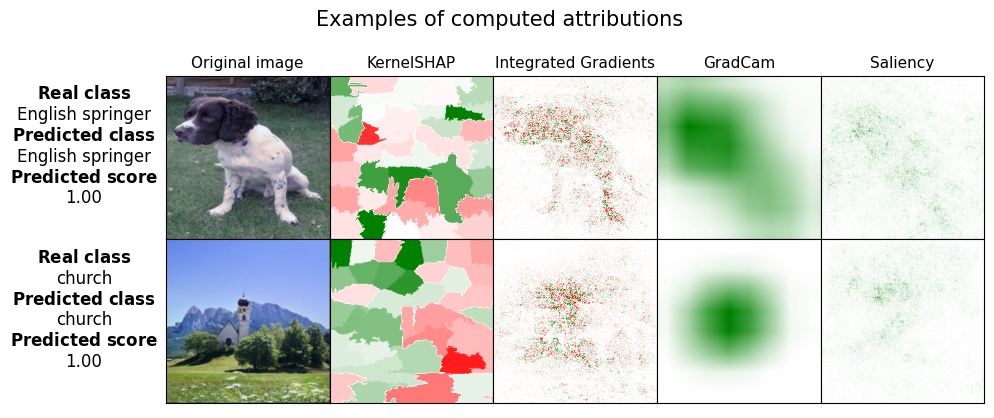

In [14]:
explainer.to_html('examples/example_report.html', model_name='DenseNet121', labels=labels)

t:\win_programs\python_venvs\autoexplainer\lib\site-packages\pylatex\figure.py:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fig" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filepath, *args, **kwargs)


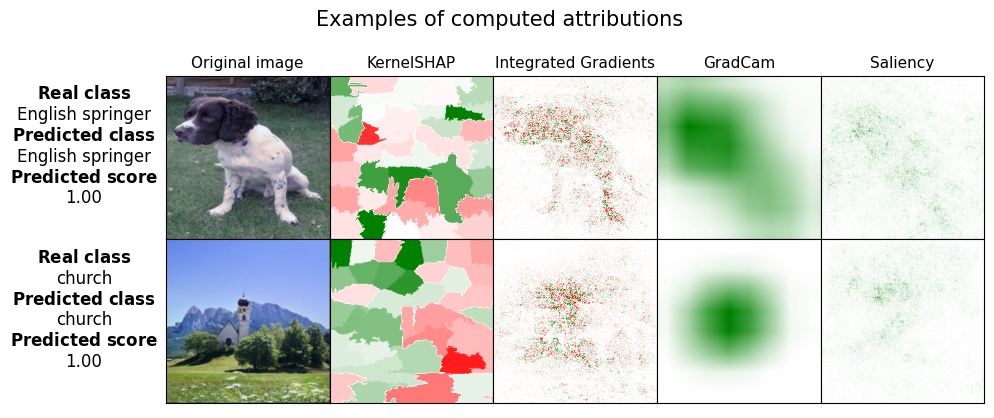

In [15]:
explainer.to_pdf('examples/', model_name='DenseNet121', dataset_name='Imagenette', labels=labels)

### Using the selected explanation method

The package comes with a handy wrapper for the selected best explanation method. It has many useful features presented below.

In [16]:
best_explanation = explainer.get_best_explanation()

First of all, you can get the name and parameters of the selected explanation method.

In [17]:
print(f"Best explanation method is {best_explanation.name}.")
print(f"It's parameters are located at 'parameters' attribute.")

Best explanation method is grad_cam.
It's parameters are located at 'parameters' attribute.


#### Viewing already computed explanations

What's more, this object already contains all attributions computed using this explanation method for images passed to the AutoeXplaier. You can access them by using `best_explanation.attributions` attribute.

In [18]:
print(f"Shape of the attributions is {best_explanation.attributions.shape}")

Shape of the attributions is torch.Size([2, 1, 256, 256])


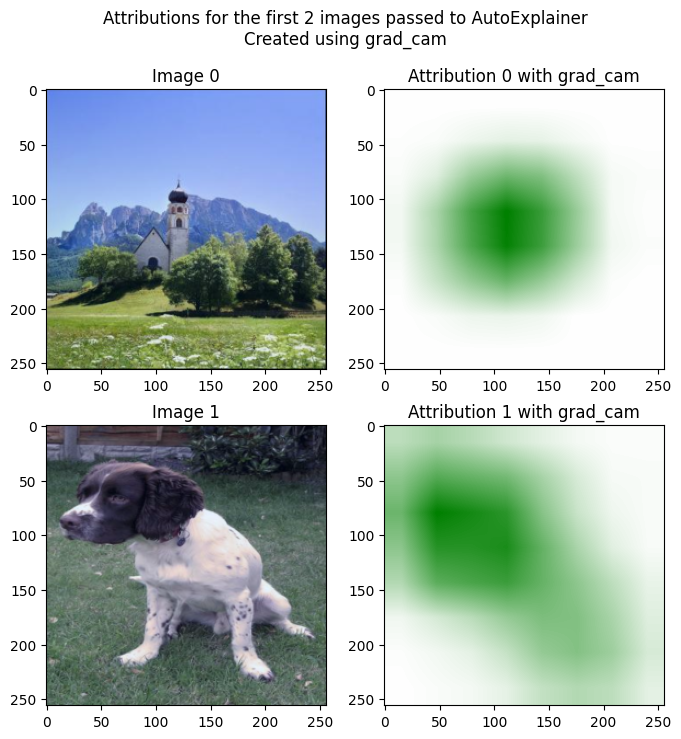

In [19]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

from autoexplainer.utils import normalize_image, torch_image_to_numpy_image

cmap = LinearSegmentedColormap.from_list("red-white-green", ["red", "white", "green"])
vmin, vmax = -1, 1

plotted_images_count = min(NUMBER_OF_IMAGES, 2)

fig, ax = plt.subplots(plotted_images_count, 2, figsize=(8, 8))
fig.suptitle(f"Attributions for the first {plotted_images_count} images passed to AutoExplainer\nCreated using {best_explanation.name}")

for i in range(plotted_images_count):
    ax[i,0].imshow(normalize_image(torch_image_to_numpy_image(x_batch[i]))); 
    ax[i,0].set_title(f"Image {i}")

    attribution = best_explanation.attributions[i, 0, :, :].cpu().detach().numpy()
    ax[i,1].imshow(attribution / np.max(np.abs(attribution)), cmap=cmap, vmin=vmin, vmax=vmax); 
    ax[i,1].set_title(f"Attribution {i} with {best_explanation.name}")

plt.show()

#### New explanations

You can also compute attributions for more images or even for a different model as below. It will use the selected best explanation method and its parameters.

In [20]:
new_attributions = best_explanation.explain(model, x_batch, y_batch)

print(f"\nShape of the new attributions is {new_attributions.shape}")

Computing attributions using GradCam method.
This may take a while, depending on the number of samples to be explained.


Calculating attributions: 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]

Finished.

Shape of the new attributions is torch.Size([2, 1, 256, 256])


### More metric scores

Lastly, it is possible to compute metric values for the selected best explanation method for more images.

In [21]:
metric_scores_raw = best_explanation.evaluate(model, x_batch, y_batch, new_attributions)
metric_scores_raw

Evaluating explanation method GradCam using 4 metrics.
	Metrics: Faithfulness Estimate, Average Sensitivity, Iterative Removal of Features, Sparseness
This may take a long time, depending on the number of samples and metrics.


Evaluating: 100%|██████████| 4/4 [02:29<00:00, 37.35s/it] 


{'faithfulness_estimate': array([0.46811493, 0.53273304]),
 'average_sensitivity': array([0.00354592, 0.02540511]),
 'irof': array([23.2196115 , 68.40751342]),
 'sparseness': array([0.69095389, 0.42930543])}

In [22]:
metric_scores_aggregated = best_explanation.evaluate(model, x_batch, y_batch, new_attributions, aggregate=True)
metric_scores_aggregated

Evaluating explanation method GradCam using 4 metrics.
	Metrics: Faithfulness Estimate, Average Sensitivity, Iterative Removal of Features, Sparseness
This may take a long time, depending on the number of samples and metrics.


Evaluating: 100%|██████████| 4/4 [02:28<00:00, 37.19s/it] 


{'faithfulness_estimate': 0.500423984264627,
 'average_sensitivity': 0.01406509312801063,
 'irof': 45.81356245658303,
 'sparseness': 0.560129660067489}

## Short addition: showing computed explanations, quick

Here, an internal function is used to return a figure with sample explanations computed.


Preparing explanation methods and metric handlers...

	Number of explanation methods to evaluate:  2
	Explanation methods selected: GradCam, Saliency

	Number of metrics used during evaluation:  1
	Metrics selected: Sparseness


Creating attributions for saliency: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


Creating attribution finished. Starting evaluation.
Evaluation may take a very long time, please be patient...


Evaluating: method saliency and metric sparseness: 100%|██████████| 2/2 [00:00<00:00, 10.67it/s]


Evaluating metrics finished after 1.823 seconds.


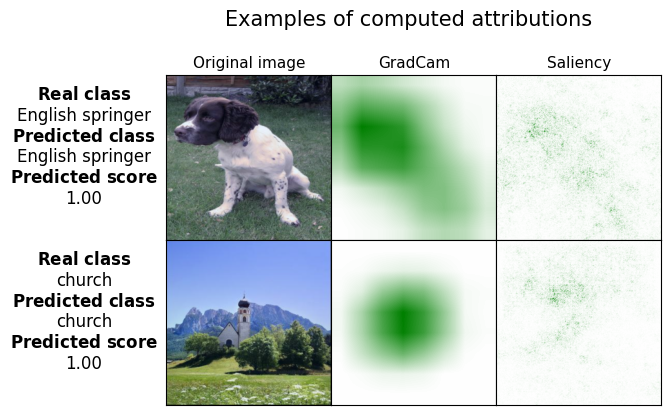

In [23]:
from autoexplainer.autoexplainer import AutoExplainer

explainer = AutoExplainer(model, x_batch, y_batch, device="cpu")
explainer.evaluate(explanations=["grad_cam", "saliency"], metrics=["sparseness"])
plot = explainer._generate_plot_for_report(count_of_images=2, labels=labels)